In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [3]:
covid_df = pd.read_csv('ny_multi_df.csv', parse_dates=['Date'])
covid_df[['new_cases_150_lag']]

,new_cases_150_lag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
785,4937.0
786,3247.0
787,4506.0
788,3994.0


In [4]:
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_df.set_index('ds', inplace=True)

In [5]:
covid_df

,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,Series_Complete_5to17,Series_Complete_12Plus,...,new_cases_50_lag,new_cases_150_lag,new_cases_350_lag,new_deaths_1_lag,new_deaths_2_lag,new_deaths_3_lag,new_deaths_4_lag,new_deaths_7_lag,new_deaths_30_lag,new_deaths_50_lag
ds,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25,5563.2,8978122.0,8976870.0,8632344.0,8030637.0,2095773.0,7975712.0,7975460.0,854760.0,7670230.0,...,1059.0,4937.0,912.0,11.0,4.0,9.0,15.0,0.0,10.0,7.0
2022-04-26,5563.2,8979720.0,8978466.0,8633797.0,8031972.0,2096333.0,7977386.0,7977134.0,854955.0,7671784.0,...,632.0,3247.0,959.0,8.0,11.0,4.0,9.0,29.0,4.0,14.0
2022-04-27,5563.2,8981357.0,8980100.0,8635249.0,8033283.0,2096769.0,7979660.0,7979406.0,855282.0,7673827.0,...,667.0,4506.0,1143.0,11.0,8.0,11.0,4.0,11.0,8.0,11.0


In [6]:
train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [7]:
covid_train = covid_train[['y', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_10_mean', 'new_cases_350_lag', 'new_cases_1 lag', 'new_cases_150_lag', 'new_cases_2_lag', 'new_cases_30_lag', 'minimum_temperature_celsius', 'new_cases_10_std', 'new_cases_10_max', 'new_cases_7_lag', 'new_cases_10_min', 'relative_humidity', 'new_cases_3_lag', 'new_cases_50_std']]
covid_test = covid_test[['y', 'PEOPLE_DEATH_NEW_COUNT', 'new_cases_10_mean', 'new_cases_350_lag', 'new_cases_1 lag', 'new_cases_150_lag', 'new_cases_2_lag', 'new_cases_30_lag', 'minimum_temperature_celsius', 'new_cases_10_std', 'new_cases_10_max', 'new_cases_7_lag', 'new_cases_10_min', 'relative_humidity', 'new_cases_3_lag', 'new_cases_50_std']]

In [8]:
X_train = covid_train.drop(columns=['y'], axis=1)
y_train = covid_train['y']
X_test = covid_test.drop(columns=['y'], axis=1)
y_test = covid_test['y']

In [9]:
reg_model = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1000)
reg_model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

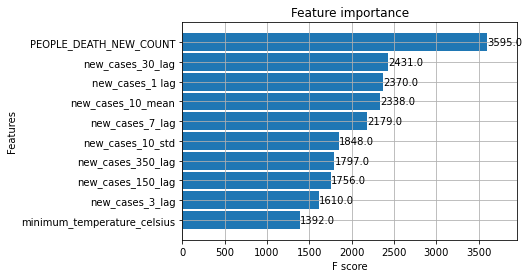

In [10]:
_ = plot_importance(reg_model, height=0.9 ,max_num_features = 10)

<AxesSubplot:xlabel='ds'>

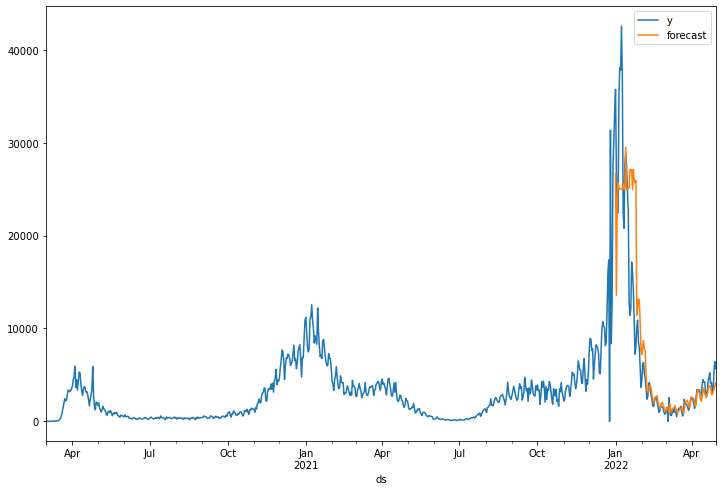

In [11]:
covid_test['forecast'] = reg_model.predict(X_test)

prophet_df_multi = pd.DataFrame(covid_df)

prophet_df_multi['forecast']=covid_test['forecast']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

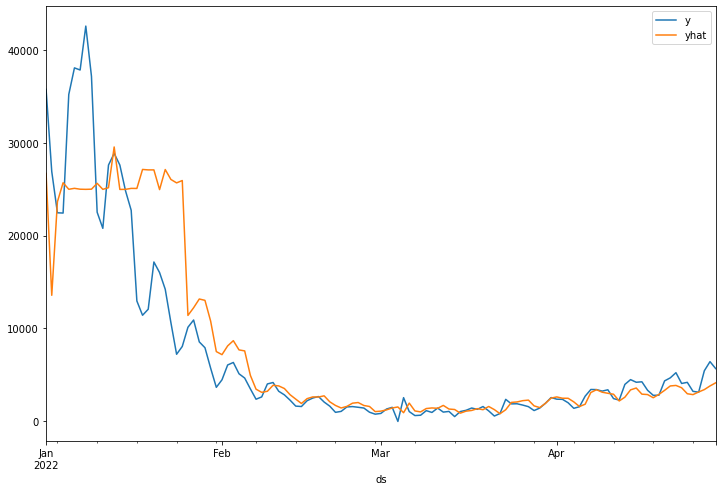

In [12]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = covid_test['forecast'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [13]:
model_rmse = mean_squared_error(covid_test['y'], covid_test['forecast'], squared=False)
model_mae = mean_absolute_error(covid_test['y'], covid_test['forecast'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)
print('MASE = ', mase(covid_test['y'], covid_test['forecast']))

Test RMSE:  5215.688115243015
Test MAE:  2636.1555463005516
MASE =  1.9917424634933543


In [14]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

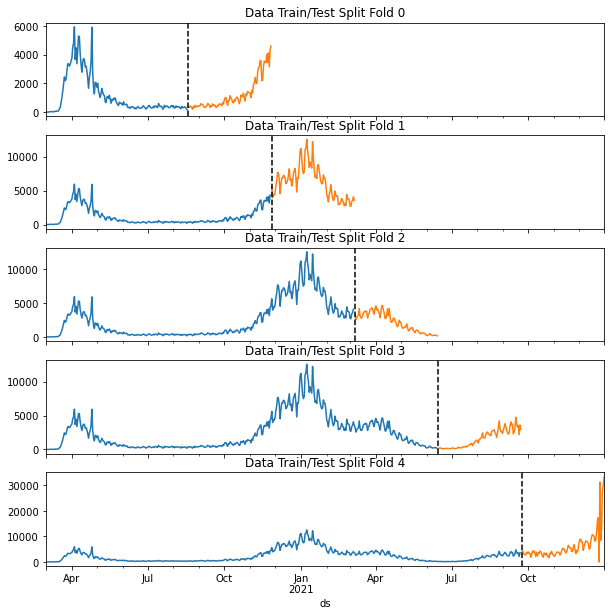

In [15]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_train):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    train['y'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['y'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [16]:
tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)
covid_df = covid_df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(covid_train):
    train = covid_df.iloc[train_idx]
    test = covid_df.iloc[val_idx]
    TARGET = 'y'

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=20,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)  

[19:47:57] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4432.19735	validation_1-rmse:11956.88618
[100]	validation_0-rmse:1915.99448	validation_1-rmse:5928.21815
[200]	validation_0-rmse:948.79052	validation_1-rmse:4996.21305
[275]	validation_0-rmse:659.67036	validation_1-rmse:4922.43141
[19:47:58] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4432.19735	validation_1-rmse:11956.88618
[100]	validation_0-rmse:1915.99448	validation_1-rmse:5928.21815
[200]	validation_0-rmse:948.79052	validation_1-rmse:4996.21305
[275]	validation_0-rmse:659.67036	validation_1-rmse:4922.43141
[19:47:58] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated

<AxesSubplot:xlabel='ds'>

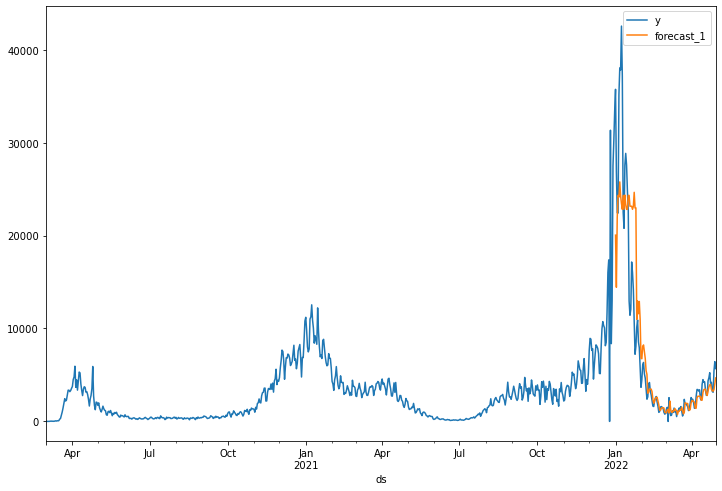

In [17]:
covid_test['forecast_1'] = reg.predict(X_test)

prophet_df_multi = pd.DataFrame(covid_df)

prophet_df_multi['forecast_1']=covid_test['forecast_1']

prophet_df_multi[['y', 'forecast_1']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

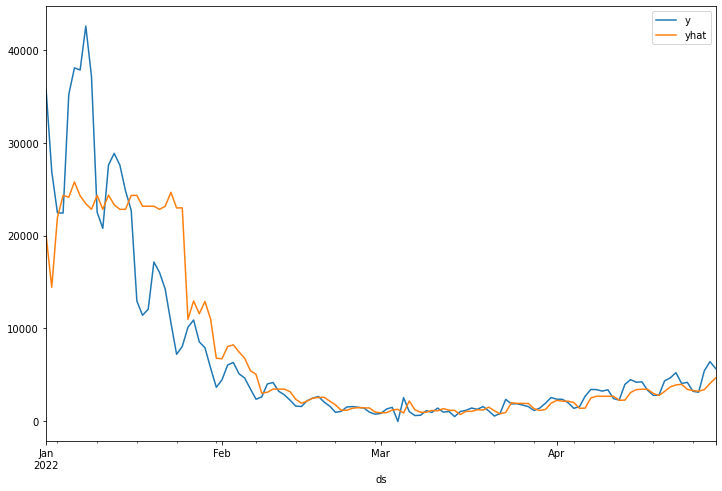

In [18]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = covid_test['forecast_1'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [19]:
model_rmse = mean_squared_error(covid_test['y'], covid_test['forecast'], squared=False)
model_mae = mean_absolute_error(covid_test['y'], covid_test['forecast'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)
print('MASE = ', mase(covid_test['y'], covid_test['forecast']))

Test RMSE:  5215.688115243015
Test MAE:  2636.1555463005516
MASE =  1.9917424634933543
